## LLM Long-/Short- Distance Conceptualization Part II

This experiment tests LLMs' conceptualization on distance considering different regions.

### Libraries

In [97]:
from openai import OpenAI, RateLimitError, APIError, APITimeoutError, AuthenticationError, BadRequestError, NotFoundError
from google.api_core.exceptions import ResourceExhausted, RetryError, DeadlineExceeded
import google.generativeai as genai

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import folium
import seaborn as sns

import time
import os
import ast
from tqdm import tqdm
import requests

### Layout

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_seq_items', None)

### Data

We use GeoNames api to get country or region names and relevant information (area) for this experiment.

In [100]:
# username is hidden in another file
with open('api.txt', 'r', encoding='utf-8') as file:
    lines = [line.strip() for line in file.readlines()]
    username = str(lines[5])
    url = f"http://api.geonames.org/countryInfoJSON?username={username}"
    
    response = requests.get(url)

In [101]:
data = response.json()['geonames']
data_dict = {i['countryName']: i['areaInSqKm'] for i in data}

In [102]:
len(data_dict)

250

In [103]:
data

[{'continent': 'EU',
  'capital': 'Andorra la Vella',
  'languages': 'ca',
  'geonameId': 3041565,
  'south': 42.4287475,
  'isoAlpha3': 'AND',
  'north': 42.655887500000006,
  'fipsCode': 'AN',
  'population': '77006',
  'east': 1.7866939,
  'isoNumeric': '020',
  'areaInSqKm': '468.0',
  'countryCode': 'AD',
  'west': 1.4135734,
  'countryName': 'Andorra',
  'postalCodeFormat': 'AD###',
  'continentName': 'Europe',
  'currencyCode': 'EUR'},
 {'continent': 'AS',
  'capital': 'Abu Dhabi',
  'languages': 'ar-AE,fa,en,hi,ur',
  'geonameId': 290557,
  'south': 22.6315119400001,
  'isoAlpha3': 'ARE',
  'north': 26.0693916590001,
  'fipsCode': 'AE',
  'population': '9630959',
  'east': 56.381222289,
  'isoNumeric': '784',
  'areaInSqKm': '82880.0',
  'countryCode': 'AE',
  'west': 51.5904085340001,
  'countryName': 'United Arab Emirates',
  'postalCodeFormat': '##### #####',
  'continentName': 'Asia',
  'currencyCode': 'AED'},
 {'continent': 'AS',
  'capital': 'Kabul',
  'languages': 'fa-AF

### Pre-defined variables

Anything you want to set as prior, such as max token, temperature, top-p, logprob, etc.

In [22]:
MAX_TOKEN = 16
TEMPERATURE = 0.7

### General commands for getting response

We employ 3 different models: gpt-5.1, gemini-2.5-flash, and deepseek-3.2-chat via API provided by them. For all models we consider the same temperature (0.7) and run each experiment for 30 times to get threshold.

In [26]:
def api_def(provider):
    # API keys are hidden in another file
    with open('api.txt', 'r', encoding='utf-8') as file:
        lines = [line.strip() for line in file.readlines()]

        # Different LLMs need different kinds of command
        if provider == 'chatgpt':
            client = OpenAI(api_key=str(lines[0]), base_url="https://api.openai.com/v1")
            return client
        
        elif provider == 'deepseek':
            client = OpenAI(api_key=str(lines[1]), base_url="https://api.deepseek.com")
            return client
        
        elif provider == 'gemini':
            genai.configure(api_key=str(lines[4]))

In [27]:
def get_completion(prompt, provider, model):
    messages = [{"role": "system", "content": "You are participating in our social survey. Please simply answer the question without deep thinking"},
               {"role": "user", "content": prompt}]

    # Different LLMs need different kinds of command
    if provider == 'gpt':
        client = api_def('chatgpt')
        response = client.responses.create(
            model=model,
            input=messages,
            temperature=TEMPERATURE,
            max_output_tokens = MAX_TOKEN
            # reasoning_effort = high
        )
        return response.output_text
        
    elif provider == 'ds':
        client = api_def('deepseek')
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=TEMPERATURE
        )
        return response.choices[0].message.content

    elif provider == 'gemini':
        api_def('gemini')
        model_gemini = genai.GenerativeModel(model)
        response = model_gemini.generate_content(
            prompt,
            generation_config={"temperature": TEMPERATURE, "max_output_tokens": MAX_TOKEN * 5}
        )
        return response.text 

In [38]:
def QA(provider, model, region):
    prompt = f"""
    As a person from {region}, in your opinion, how many kilometers of a human migration can be called as \
    a "long-distance migration" rather than a "short-distance migration"? \
    Output only one exact number. Note that we don't have any other category in this scheme like "medium distance". \n
    Do not infer any missing information. Output only the exact number without any other thing such as \
    explanations, opinions, inferences or meta-comments. 
    """
    response = get_completion(prompt, provider, model)
    return response

In [39]:
def QA_to_df(provider, model, region, area):
    results = []
    fail_count = 0
    
    for run_id in range(30):
        success = False
        while not success:
            try:
                result = {"answer": QA(provider, model, region)}
                result["region"] = region
                result["area"] = area
                result["model"] = model
                result["run"] = run_id
                results.append(result)
                success = True
            except (RateLimitError, APIError, APITimeoutError, ResourceExhausted, ValueError) as e: # AuthenticationError, BadRequestError, NotFoundError
                time.sleep(1)
                fail_count = fail_count + 1
                if fail_count >= 10:
                    raise ValueError(f"Can't get response: {result}, retried too many times") from e

    df = pd.DataFrame(results)    
    return df

In [47]:
def batch_response_to_df(provider, model, region_dict):

    save_path = f"results_region/{provider}.csv"
    os.makedirs("results_region", exist_ok=True)

    region_list = list(region_dict.keys())

    if os.path.exists(save_path):
        df = pd.read_csv(save_path)
        processed_regions = set(df["region"].unique())

        start_index = 0
        for i, region in enumerate(region_list):
            if region not in processed_regions:
                print(f"Start from region {region}")
                start_index = i
                break
        else:
            return df
        
    else:
        df = pd.DataFrame()
        start_index = 0

    for i in tqdm(range(start_index, len(region_list))):
        region = region_list[i]
        area = region_dict[region]
        
        region_df  = QA_to_df(provider, model, region, area)
        df = pd.concat([df, region_df], ignore_index=True)
        df.to_csv(save_path, index=False)

    return df

In [49]:
gpt51_1 = batch_response_to_df('gpt', 'gpt-5.1', data_dict)

100%|██████████| 250/250 [2:40:07<00:00, 38.43s/it]  


In [51]:
gemini_25_1 = batch_response_to_df('gemini', 'gemini-2.5-flash', data_dict)

100%|██████████| 250/250 [2:23:39<00:00, 34.48s/it]  


In [52]:
ds_32_1 = batch_response_to_df('ds', 'deepseek-chat', data_dict)

100%|██████████| 250/250 [2:45:33<00:00, 39.73s/it]  


### Analysis

In [53]:
df_dict = {}

for file_name in os.listdir('results_region/'):
    if file_name.endswith('.csv'):
        file_path = os.path.join('results_region/', file_name)

        df = pd.read_csv(file_path)
        df_name = file_name.replace('.csv', '')
        df_dict[df_name] = df

all_result = pd.concat(df_dict.values(), axis=0, ignore_index=True)

In [112]:
all_result_clean = all_result.copy()
all_result_clean['answer'] = pd.to_numeric(all_result_clean['answer'], errors='coerce')
all_result_clean = all_result_clean.dropna(subset=['answer'])
grouped_result = all_result_clean.groupby(['region', 'area', 'model']).agg({'answer': 'mean'}).reset_index()

We simply have a look at the correlation between area of region and perceived threshold between long and short distance.

In [76]:
def plot(df, model, pos):    
    subset = df[(df['model'] == model)]
    
    plt.figure(figsize=(12,4))
    plt.title(f"{model}", fontsize=14, pad=10)
        
    plt.scatter(subset['area'], subset['answer'], s=30, alpha=0.7, c='steelblue')
    
    plt.xlabel('Area of regions', fontsize=12)
    plt.ylabel('Perceived threshold', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 2e6)
    plt.ylim(0, 1000)
    plt.xticks(np.arange(0, 2e6+1, 4e5), labels=[f'{int(x):,}' for x in np.arange(0, 2e6+1, 4e5)], fontsize=9)
    plt.yticks(np.arange(0, 1001, 200), fontsize=9)
    filepath = os.path.join(pos, f"{model}.png")
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()

In [77]:
for model in grouped_result['model'].unique():
    plot(grouped_result, model, 'plots/region')

In [113]:
grouped_result['continent'] = grouped_result['region'].apply(lambda region: next((d['continent'] for d in data if d['countryName'] == region), None))
grouped_result_EU = grouped_result[(grouped_result['continent'] == 'EU')]

/tmp/ipykernel_667618/1867793841.py:2: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



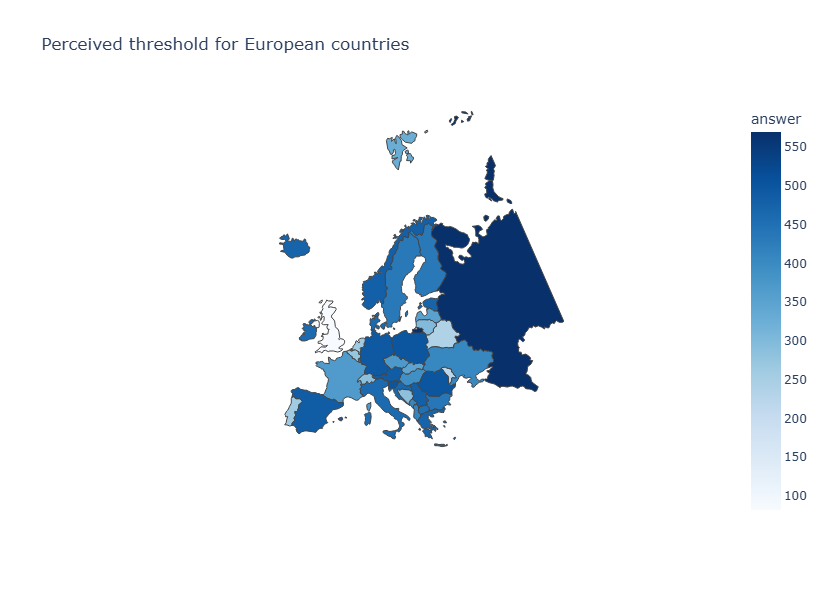

In [119]:
grouped_result_EU_gpt = grouped_result_EU[(grouped_result_EU['model'] == 'gpt-5.1')]
fig = px.choropleth(grouped_result_EU_gpt, locations='region', locationmode='country names',
                    color='answer', scope='europe', color_continuous_scale='Blues',
                    title='Perceived threshold for European countries')

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(height=600, width=800)
fig.show()

fig.write_html("europe_map.html")